### Middleware

**Middleware** provides a way to more tightly control what happens inside the agent.**Middleware** is useful for the following:

- Tracking agent behavior with logging, analytics, and debugging.
- Transforming prompts, tool selections, and output formating.
- Addding retries, fallbacks, and early termination logic.
- Applying rate limits, guardrails, and PII Detection

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

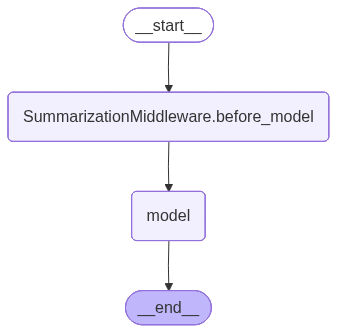

In [7]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage, SystemMessage

# Agent with Message Based Summarization

agent = create_agent(
  model= "gpt-5",
  checkpointer= InMemorySaver(),
  middleware= [
    SummarizationMiddleware(
      model = "gpt-5",
      trigger=("messages", 10),
      keep=("messages", 4),
    )
  ]
)
agent

In [8]:
# Thread Id
config = {"configurable": {"thread_id": "test1"}}

In [9]:
# questions = [
#   "What is the capital of France?",
#   "What is the capital of Germany?",
#   "What is the capital of Italy?",
#   "What is the capital of Spain?",
#   "What is the capital of Portugal?",
# ]


questions = [
  "What is 2+2?",
  "What is 10*5?",
  "What is 100/2?",
  "What is 100/4?",
  "What is 100/5?",
  "What is 100/10?",
  "What is 100/20?",
  "What is 100/40?",
]

for question in questions:
  response = agent.invoke({"messages": [HumanMessage(content=question)]}, config=config)
  # print(response["messages"][-1].content)
  # print(f"Messages:{question} :{response["messages"][-1].content}")
  print(f"Messages:{question} :{response}")
  print(f"Messages: {len(response['messages'])}")



KeyboardInterrupt: 

In [5]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.tools import tool
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")



@tool
def search_hotels(city: str) -> str:
  """Search hotels - returs long response to use more tokens"""
  return f"""Hotels in {city}
  1. Grand Hotel - 5 star, $350/night, spa, pool, gym
  2. City Inn - 4 star, $180/night, business center
  3. Budget Stay - 3 star, $75/night, free wifi
  """
  
agent = create_agent(
  model= "gpt-5",
  tools= [search_hotels],
  checkpointer= InMemorySaver(),
  middleware= [
    SummarizationMiddleware(
      model= "gpt-5",
      trigger=("tokens", 550),
      keep=("tokens", 200),
      
    )
  ]
 
  
)

agent

# Token counter
def count_tokens(messages):
  total_chars = sum(len(m.content) for m in messages)
  total_tokens = total_chars / 4
  return total_tokens


  

In [6]:
# Run test 

cities = ["Paris", "London", "New York", "Tokyo", "Dubai", "Singapore"]
# Thread Id
config = {"configurable": {"thread_id": "test13"}}

for city in cities:
  response = agent.invoke({"messages": [HumanMessage(content=f"What are the hotels in {city}?")]}, config=config)
  
  tokens = count_tokens(response["messages"])
  print(f"{city} : ~{tokens} tokens, {len(response['messages'])} messages")
  print(f"{response['messages']}")

Paris : ~122.0 tokens, 4 messages
[HumanMessage(content='What are the hotels in Paris?', additional_kwargs={}, response_metadata={}, id='5d4a87e8-c6f6-4153-a0d1-d73235afa5b0'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 344, 'prompt_tokens': 138, 'total_tokens': 482, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-Cy1QWXsvCfNZ1S80babdlFeTiGQ2G', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bbe1e-1024-7190-ac54-c98715f47305-0', tool_calls=[{'name': 'search_hotels', 'args': {'city': 'Paris'}, 'id': 'call_3pqjDieXEs8ZlmctblAn98JJ', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 13

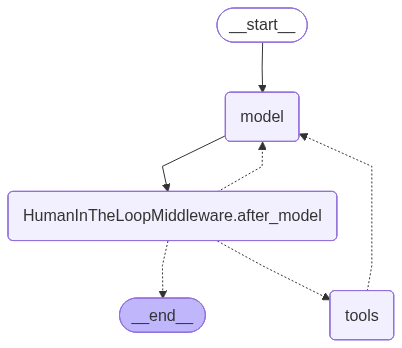

In [53]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver


def read_email_tool(email_id: str) -> str:
    """Mock function to read an email by its ID."""
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient: str, subject: str, body: str) -> str:
    """Mock function to send an email."""
    return f"Email sent to {recipient} with subject '{subject}'"

agent = create_agent(
    model="gpt-4o-mini",
    tools=[read_email_tool, send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool": {
                    "allowed_decisions": ["approve", "edit", "reject"],
                },
                "read_email_tool": False,
            }
        ),
    ],
)

agent

In [54]:
config = {"configurable": {"thread_id": "test-approve"}}

# Step 1: Request 
result = agent.invoke({"messages": [HumanMessage(content= " Send an email to john@test.com with subject 'Meeting and body 'Get ready for meeeting'")]}, config=config)

In [55]:
result


{'messages': [HumanMessage(content=" Send an email to john@test.com with subject 'Meeting and body 'Get ready for meeeting'", additional_kwargs={}, response_metadata={}, id='5b503af5-fd62-46f5-892c-ed54279dd000'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 99, 'total_tokens': 128, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-Cy26yy8m65hyJgdPwte8Ckz4nryGM', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bbe46-3ddb-72a2-871f-0231241395e1-0', tool_calls=[{'name': 'send_email_tool', 'args': {'recipient': 'john@test.com', 'subject': 'Meeting', 'body': 'Get ready for meeeting

In [41]:
from langgraph.types import Command

# Step 2: Approve

if "__interrupt__" in result:
  print("Approving")
  
  result=agent.invoke(
    Command(
      resume={
        "decisions":[
          {"type": "approve"}
        ]
      }
    ),
    config=config
  )
  
  print(f"✅ Result : {result['messages'][-1].content}")

Approving
✅ Result : The email has been sent to john@test.com with the subject "Meeting" and the body "Get ready for meeeting."


In [56]:
from langgraph.types import Command

# Step 2: Reject

if "__interrupt__" in result:
  print("⏸️Paused! Rejecting...")
  
  result=agent.invoke(
    Command(
      resume={
        "decisions":[
          {"type": "reject"}
        ]
      }
    ),
    config=config
  )
  
  print(f"❌ Rejected: {result['messages'][-1].content}")

⏸️Paused! Rejecting...
❌ Rejected: 
